# Use projecc to create figures in the paper

In [1]:
from projecc import *
import matplotlib.pyplot as plt
import numpy as np
from astropy.time import Time
import astropy.units as u

# GJ 876 b
https://exoplanetarchive.ipac.caltech.edu/overview/GJ%20876


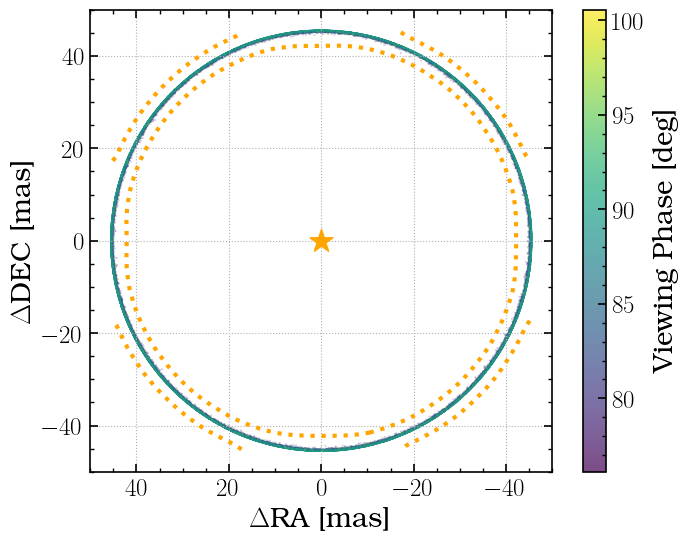

In [2]:
### Supply tuples of [mean, std dev] of orbit parameters:

# Rivera 2010:
sma = [0.2083, 0.00002] #u.au
Period = [61.1166, 0.0086] # days
ecc = [0.0324, 0.0013]
Mp = [723.2235, 1.4302] # Mearth
argp = [50.3, 3.2] # degrees
# Argument of periastron is reported as argp of the star, so we
# need to apply 180deg offset to get argp of planet:
argp = [(argp[0] + 180)%360, argp[1]]
# longitude of nodes is unconstrained, so
# set it to nan to draw lan from uniform distribution:
lan = np.nan
# Rivera reports a new 4th planet and finds this inclination for
# thier 4-planet fit:
incl = [61, 2.4] # deg
# Star parametrs:
Mstar = [0.36960720960300, 0.00925103268102] 
plx = [213.867, 0.076] #mas

# They use mean anom past a reference date as the timing parameter:
MA = [325.7,3.2] # deg
# Reference date:
tref = Time('2450602.093', format='jd')
# Compute epoch of periastron passage, where MA = 2pi * (tref - t0)/P
# using a Monte Carlo simulation to propagate errors:
Periodarray = (MonteCarloIt(Period)*u.d.to(u.yr))
t0 = tref.decimalyear - (Periodarray * MonteCarloIt([np.radians(MA[0]),np.radians(MA[1])])) / (2*np.pi)
# Convert to julian days:
t01 = Time(np.mean(t0), format='decimalyear')
t0 = [t01.jd, np.std(t0)*u.yr.to(u.d)]


# Put parameters into a Planet object:
gj876 = Planet(sma,ecc,incl,argp,lan,Period,t0,Mp,Mstar,plx, 
               Mp_is_Mpsini = False # set if the supplied planet mass is an Msini value or a mass value. 
               # If True, Mp will be divided by sin(incl). Default is True. Here we have inclination 
               # estimate and the literature mass is the true planet mass estimate.
              )

# Create a simulation of points at desired date. The Planet object automatically predicts the date of
# maximum planet-star separation, so let's use that:
date = gj876.date_of_max_elongation
points_rivera = OrbitSim(gj876, date)

# make a scatter plot of all simulated points color-coded by viewing phase:
fig = MakeCloudPlot(points_rivera)

The points appear as a ring because the star-planet separation is well constrained by this solution, but the longitude of nodes is not, and is drawn from a uniform distribution on (0,360) deg.  All points are near quadrature at this time.

/Users/loganpearce/anaconda3/envs/py39/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


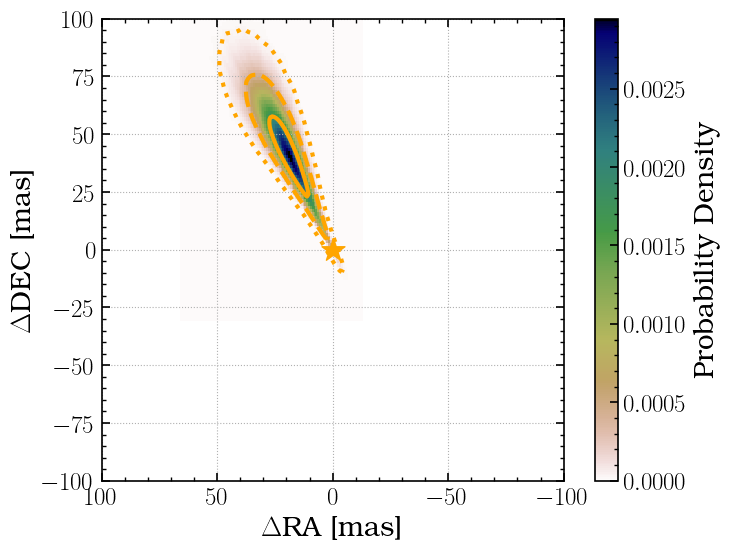

In [3]:
### Benedict 2002 solution:

sma = [0.22, 0.08] #u.au
Period = [61.02, 0.03] # days
ecc = [0.1, 0.02]
Mp = [1.89, 0.34] # Mjup
Mp = [Mp[0]*u.Mjup.to(u.Mearth), Mp[1]*u.Mjup.to(u.Mearth)]
argp = [338.96, 0.36]
argp = [(argp[0] + 180)%360, argp[1]]
lan = [25,4]
t0 = [2450107.9, 1.9]
incl = [84,6]

Mstar = [0.36960720960300, 0.00925103268102] 
plx = [213.867, 0.076] #mas


gj876 = Planet(sma,ecc,incl,argp,lan,Period,t0,Mp,Mstar,plx, Mp_is_Mpsini = False)
points_benedict = OrbitSim(gj876, gj876.date_of_max_elongation)
### Make probability density map:
# Set the grid size for the kernel density estimation map:
kdesize=100j
# Set the limits of the plot:
lim = 100
fig = MakeKDEPlot(points_benedict, lim = lim, kdesize=kdesize)

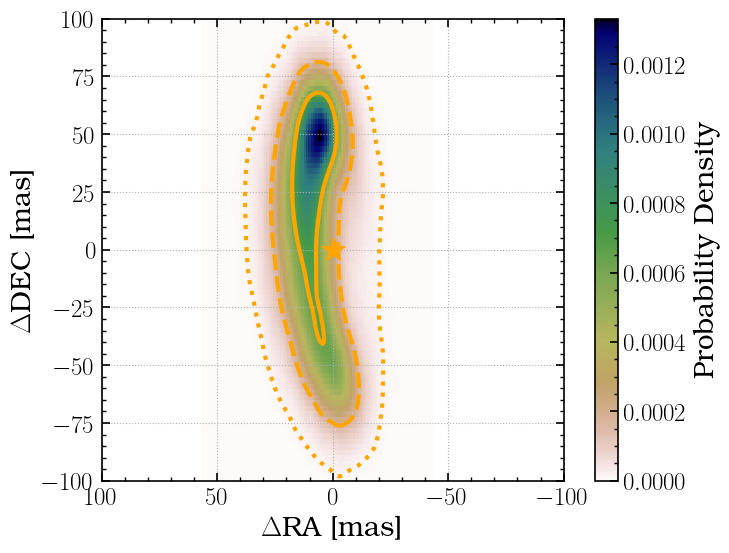

In [4]:
### Gaia DR3 NSS solution:

gaia_sourceid = '2603090003484152064'

# This function automatically queries the Gaia archive and retrieves the NSS solution,
# then uses NSS Tools to convert the Thiele-Innes elements to Campbell elements.
elements = GetGaiaOrbitalElementsWithNSSTools(gaia_sourceid)

# NSS supplies star's perturbation semi-major axis
# so we need to convert star sma to planet sma. Sma goes as planet-star mass ratio:
sma_star = elements['sma [mas]']
# Mass ratio is unknown in nss so we can use the other mass estimates
Mp = [723.2235, 1.4302] # <- Rivera 2010 mass
# Use Monte Carlo to propagate errors:
Mp_array = MonteCarloIt(Mp)*u.Mearth.to(u.Msun)
# Get star mass and parallax
Mstar = [0.36960720960300, 0.00925103268102] 
plx = [213.867, 0.076]
# Compute mass ratio:
q = Mp_array/MonteCarloIt(Mstar)
# compute planet sma in mas:
sma_p_mas = MonteCarloIt(sma_star)/q
# convert to sma in au:
sma_p_au = (sma_p_mas/1000) * 1000/(MonteCarloIt(plx))
# get mean and std dev to feed into Planet object:
sma_p_au = [np.mean(sma_p_au),np.std(sma_p_au)]

Period = elements['P [d]'] # days
ecc = elements['ecc']
inc = elements['inc [deg]']
argp = elements['argp [deg]'] # degrees
# Since NSS is also looking at the star perturbation,
# we need to convert to the planet argp:
argp = [(argp[0] + 180)%360, argp[1]]
# NSS limits lan to [0,180] deg due to degeneracy with argp. In this case, the
# alternate lan value matches the other solutions better, so let's add 180:
lan = [(elements['lan [deg]'][0] + 180) % 360,elements['lan [deg]'][1]]

# NSS gives T0 in days since 2016.0 (ref epoch for DR3), which we need to convert to julian days:
from astropy.time import Time
t01 = Time(elements['T0 [yr]'][0], format='decimalyear')
t0 = [t01.jd, elements['T0 [yr]'][1]*u.yr.to(u.d)]


gj876_gaia = Planet(sma_p_au,ecc,inc,argp,lan,Period,t0,Mp,Mstar,plx, Mp_is_Mpsini=False)
gaiapoints = OrbitSim(gj876_gaia, gj876.date_of_max_elongation)
# Make probability density map:
# Set the grid size for the kernel density estimation map:
kdesize=100j
# Set the limits of the plot:
lim = 100
fig = MakeKDEPlot(gaiapoints, lim = lim, kdesize=kdesize)

### Put the three solutions together:

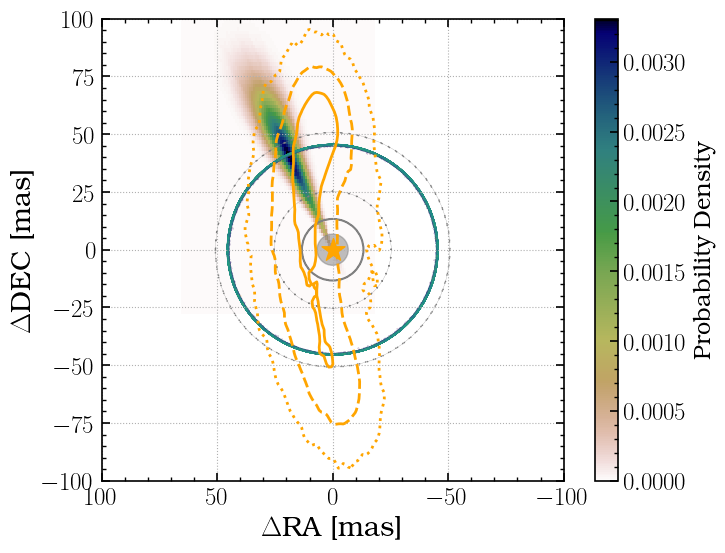

In [44]:


fig,ax = plt.subplots()
plt.scatter(0,0, marker='*',color='orange',s=300, zorder=10)

# Make probability density plot for Benedict 02 solution:
ind = np.isfinite(points_benedict.dec_mas)
kde, xmin, ymin, xmax, ymax = GetKDE(points_benedict.ra_mas[ind],points_benedict.dec_mas[ind], size=100j)
kdenormed = kde/np.sum(kde) # sums to 1 -> it's a PDF
a = ax.imshow(kdenormed, cmap=plt.cm.gist_earth_r, extent=[xmin, xmax, ymin, ymax])
cbar = plt.colorbar(a)
cbar.ax.set_ylabel('Probability Density',fontsize=17)


# Make scatter plot for Rivera 2010 solution:
pp = ax.scatter(points_rivera.ra_mas, points_rivera.dec_mas, ls='None', marker='.', alpha = 0.7, 
                c=points_rivera.phases, 
                cmap='viridis', s=0.1)

# Make histogram for Gaia solution
linestyles=[':','--','-']
H, xbins, ybins, midpoints, clevels = GetHist(gaiapoints.ra_mas, gaiapoints.dec_mas, sigmas = [1,2,3])
ax.contour(*midpoints, gaussian_filter(H.T, sigma=1), levels = clevels, 
              linewidths=2, linestyles = linestyles, colors=['orange']*len(linestyles))

lim = 100
ax.set_xlim(-lim,lim)
ax.set_ylim(-lim,lim)
ax.invert_xaxis()
ax.set_aspect('equal')
ax.set_xlabel('$\Delta$RA [mas]')
ax.set_ylabel('$\Delta$DEC [mas]')
ax.grid(ls=':')

import matplotlib.patches as patches
# Compute size of GMT lambda/D at 0.8um:
gmt_lod = (0.2063*(0.8)/24.5) * 1000
# Add circles marking 1 and 2 l/D
circ = patches.Circle((0,0), gmt_lod, alpha=0.5, color='grey')
fig.axes[0].add_patch(circ)
an = patches.Annulus((0,0), r=2*gmt_lod, width=0.3, color='grey', ls='-')
fig.axes[0].add_patch(an)

# Repeat for Magellan Clay telescope:
clay_lod = (0.2063*(0.8)/6.5) * 1000
an = patches.Annulus((0,0), r=clay_lod, width=0.1, color='grey', ls=(0,(1,5)))
fig.axes[0].add_patch(an)
an = patches.Annulus((0,0), r=2*clay_lod, width=0.1, color='grey', ls=(0,(1,5)))
fig.axes[0].add_patch(an)

fig.savefig('GJ876-Benedict-Rivera-Gaia.png',bbox_inches='tight')

# Proxima Centauri b

Su\'arez Mascare\~no 2020 has better constraints on $T_0$ and $\omega$ than the more recent Faria 2022, so we used the Su\'arez Mascare\~no 2020 solution.

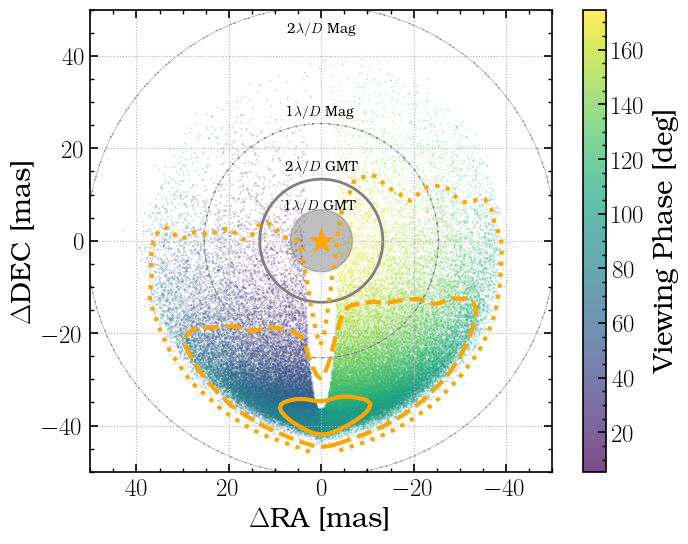

In [6]:
# Prox b's params
# from Su\'arez Mascare\~no 2020: https://ui.adsabs.harvard.edu/abs/2020A%26A...639A..77S/abstract

# sma must be in au:
sma = [0.04856,0.00029]
# Period must be in days 
Period = [11.18418,0.0007] 
ecc = [0.109,0.07]
# mass in Earth masses:
Mpsini = [1.16,0.13] #u.Mearth  
# RV orbits typically report argp for the star, so we need to apply a 180 deg shift to get
# the planet argp (reference: https://ui.adsabs.harvard.edu/abs/2022arXiv221206966H/abstract)
argp = [np.degrees(-1.9) % 360,np.degrees(0.73)]
argp = [(argp[0] + 180)%360, argp[1]]
# Longitude of nodes is undetermined with an RV-only solutions, so let's set it zero, 
# forcing the ascending node to be on the +Dec line
# so we can examine the effect of the other parameters:
lan = 0
# Epoch of periastron passage must be in Julian date with uncertainty in days:
t0 = [2458530, 1.3]
# Inclincation is unconstrained. Inc = nan will cause cos(inc) to be drawn from a uniform dis on [10,88] deg
inc = np.nan
# stellar mass:
Mstar = [0.1221,0.0022] 
# parallax in mas:
plx = [768.500000,0.203021]

# Construct the planet object
proxb = Planet(sma,ecc,inc,argp,lan,Period,t0,Mpsini,Mstar,plx, Mp_is_Mpsini=True)
points = OrbitSim(proxb, proxb.date_of_max_elongation)

fig = MakeCloudPlot(points, lim = 50)
import matplotlib.patches as patches
gmt_lod = (0.2063*(0.8)/24.5) * 1000
circ = patches.Circle((0,0), gmt_lod, alpha=0.5, color='grey')
fig.axes[0].add_patch(circ)
an = patches.Annulus((0,0), r=2*gmt_lod, width=0.3, color='grey', ls='-')
fig.axes[0].add_patch(an)
fig.axes[0].annotate('1$\lambda/D$ GMT', xy = (0.5,0.566), xycoords='axes fraction', ha='center')
fig.axes[0].annotate('2$\lambda/D$ GMT', xy = (0.5,0.65), xycoords='axes fraction', ha='center')

clay_lod = (0.2063*(0.8)/6.5) * 1000
an = patches.Annulus((0,0), r=clay_lod, width=0.1, color='grey', ls=(0,(1,5)))
fig.axes[0].add_patch(an)
an = patches.Annulus((0,0), r=2*clay_lod, width=0.1, color='grey', ls=(0,(1,10)))
fig.axes[0].add_patch(an)
fig.axes[0].annotate('1$\lambda/D$ Mag', xy = (0.5,0.77), xycoords='axes fraction', ha='center')
fig.axes[0].annotate('2$\lambda/D$ Mag', xy = (0.5,0.95), xycoords='axes fraction', ha='center')
fig.savefig('ProxCen-Cloud-Suarez.png', bbox_inches='tight')

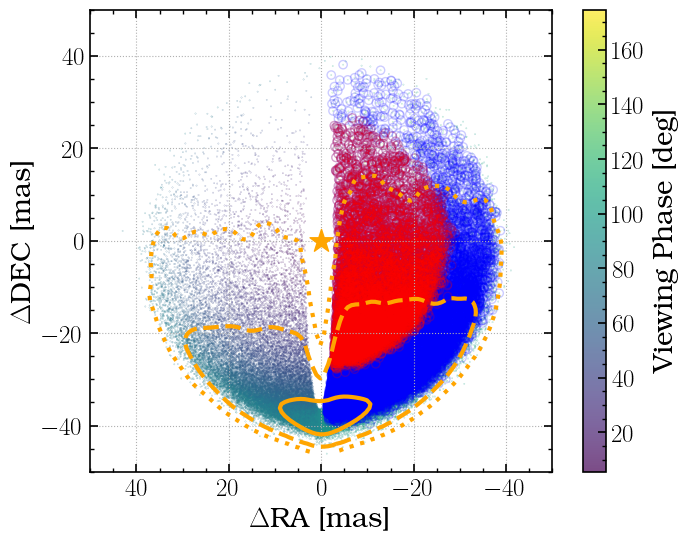

In [7]:
# At phases > 110 the contrast will be <half what it is as quadrature.  At phases > 137, the contrast will
# be less than an order of magnitude what it is a quadrature.
fig = MakeCloudPlot(points, lim = 50)
ind = np.where(np.array(points.phases)>110)[0]
fig.axes[0].scatter(points.ra_mas[ind],points.dec_mas[ind], facecolors='None', edgecolors='b',alpha = 0.2)
ind = np.where(np.array(points.phases)>137)[0]
fig.axes[0].scatter(points.ra_mas[ind],points.dec_mas[ind], facecolors='None', edgecolors='r',alpha = 0.2)
fig.savefig('ProxCen-Cloud-PhasesMarked.png', bbox_inches='tight')

### What is driving the uncertainty?
Let's artificially lower uncertainties on parameters until we get a nicely constrained location prediction.

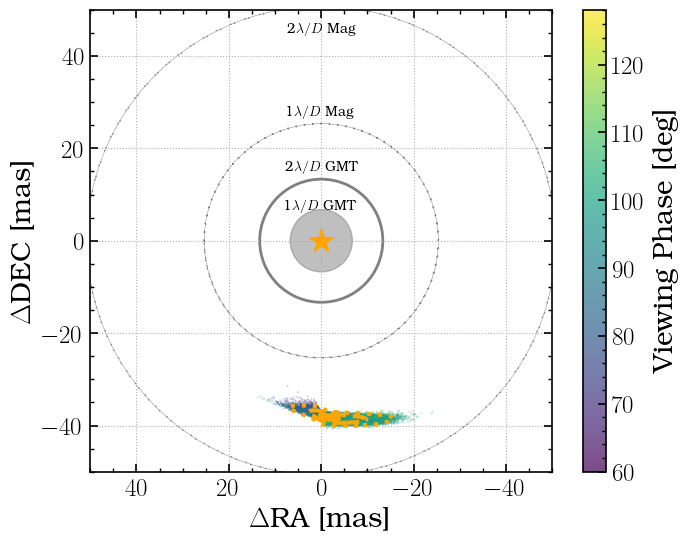

In [8]:
sma = [0.04856,0.00029]
Period = [11.18418,0.0007] 
ecc = [0.109,0.07]
Mpsini = [1.16,0.13] #u.Mearth  
argp = [np.degrees(-1.9) % 360,np.degrees(0.73)]
# What if we set the argp uncertainty to a much smaller 2 degrees:
argp = [(argp[0] + 180)%360, 2]
lan = 0
# And instead of 1.3 days let's make the T0 uncertainty be 10 hours:
t0 = [2458530, 10*u.hr.to(u.d)]
inc = np.nan
Mstar = [0.1221,0.0022] 
plx = [768.500000,0.203021]

# Construct the planet object
proxb_sm = Planet(sma,ecc,inc,argp,lan,Period,t0,Mpsini,Mstar,plx, Mp_is_Mpsini=True)
points_sm = OrbitSim(proxb_sm, proxb.date_of_max_elongation)

fig = MakeCloudPlot(points_sm, lim = 50)
import matplotlib.patches as patches
gmt_lod = (0.2063*(0.8)/24.5) * 1000
circ = patches.Circle((0,0), gmt_lod, alpha=0.5, color='grey')
fig.axes[0].add_patch(circ)
an = patches.Annulus((0,0), r=2*gmt_lod, width=0.3, color='grey', ls='-')
fig.axes[0].add_patch(an)
fig.axes[0].annotate('1$\lambda/D$ GMT', xy = (0.5,0.566), xycoords='axes fraction', ha='center')
fig.axes[0].annotate('2$\lambda/D$ GMT', xy = (0.5,0.65), xycoords='axes fraction', ha='center')

clay_lod = (0.2063*(0.8)/6.5) * 1000
an = patches.Annulus((0,0), r=clay_lod, width=0.1, color='grey', ls=(0,(1,5)))
fig.axes[0].add_patch(an)
an = patches.Annulus((0,0), r=2*clay_lod, width=0.1, color='grey', ls=(0,(1,10)))
fig.axes[0].add_patch(an)
fig.axes[0].annotate('1$\lambda/D$ Mag', xy = (0.5,0.77), xycoords='axes fraction', ha='center')
fig.axes[0].annotate('2$\lambda/D$ Mag', xy = (0.5,0.95), xycoords='axes fraction', ha='center')
fig.savefig('ProxCen-Cloud-Suarez-ReducedUncert.png', bbox_inches='tight')

# GMT Reflected Light Targets

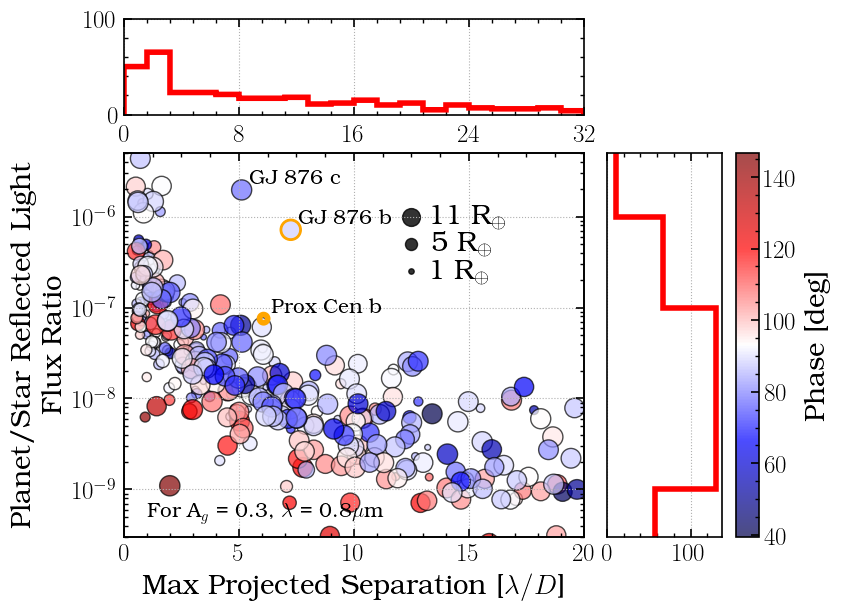

In [75]:
# Load target list with orbital parameters determined:
orbits = pd.read_csv('GMagAO-X-Target-list-with-orbital-params.csv')
# Pick out Prox Cen b:
ind = [i for i in range(len(orbits)) if 'Prox' in orbits['pl_name'][i]]
ProxCen = orbits.loc[ind].reset_index(drop = True)
# Pick out GJ 876
ind = [i for i in range(len(orbits)) if 'GJ 876 b' in orbits['pl_name'][i]]
GJ876b = orbits.loc[ind].reset_index(drop = True)
ind = [i for i in range(len(orbits)) if 'GJ 876 c' in orbits['pl_name'][i]]
GJ876c = orbits.loc[ind].reset_index(drop = True)

import matplotlib as mpl
# Select only one accessible to GMT:
ind = np.where((np.array(orbits['MaxProjectedSeparation_lod_gmagaox']) > 0.5) & 
               (np.array(orbits['dec']) < 20) & 
               (np.array(orbits['dec']) > -65) 
              )[0]


# Plot max projected separation in GMT lambda/D
plotx = np.array(orbits['MaxProjectedSeparation_lod_gmagaox'])[ind]
# vs Contrast at that separation:
ploty = np.array(orbits['ContrastAtMaxProj'])[ind]
# Pull out relevant parameters:
rad = np.array(orbits['PlanetRadiuse'])[ind]
#spt = np.array(orbits['SpT Number'])[ind]
phases = np.array(orbits['PhaseAtMaxProj'])[ind]
sepau = np.array(orbits['MaxProjectedSeparation_au'])[ind]
sepmas = np.array(orbits['MaxProjectedSeparation_mas'])[ind]

# set some things for the plot:
xaxis_label = r'\[ \mathrm{Max\; Projected\; Separation}\; [\lambda/D]\]'
annotation_text = r"$$\mathrm{For}\; i'\; filter, \;D = 25.4m\$$"
output_file_name = 'TargetList-GMagAOX-Max-separation-contrast'

# normalize colors:
colorby = phases
norm = mpl.colors.Normalize(vmin=min(phases), vmax=np.max(phases))


# set up figure:
fig = plt.figure()
ax = fig.add_gridspec(top=0.75, right=0.7).subplots()
a = ax.scatter(plotx, ploty, 
            c=phases, cmap='seismic', s=rad*15, alpha =0.7, norm=norm, edgecolor='black')
ax.scatter(ProxCen['MaxProjectedSeparation_lod_gmagaox'][0], ProxCen['ContrastAtMaxProj'][0],
         edgecolors = 'orange', lw=4, color='None')
ax.annotate('Prox Cen b', xy = (ProxCen['MaxProjectedSeparation_lod_gmagaox'][0], ProxCen['ContrastAtMaxProj'][0]),
           xytext = (5,5), textcoords = 'offset points', fontsize=15)
ax.scatter(GJ876b['MaxProjectedSeparation_lod_gmagaox'][0], GJ876b['ContrastAtMaxProj'][0],
         edgecolors = 'orange', lw=2, color='None', s=200)
ax.annotate('GJ 876 b', xy = (GJ876b['MaxProjectedSeparation_lod_gmagaox'][0], GJ876b['ContrastAtMaxProj'][0]),
           xytext = (5,5), textcoords = 'offset points', fontsize=15)
# ax.scatter(GJ876c['MaxProjectedSeparation_lod_gmagaox'][0], GJ876c['ContrastAtMaxProj'][0],
#          edgecolors = 'orange', lw=2, color='None', s=200)
ax.annotate('GJ 876 c', xy = (GJ876c['MaxProjectedSeparation_lod_gmagaox'][0], GJ876c['ContrastAtMaxProj'][0]),
           xytext = (5,5), textcoords = 'offset points', fontsize=15)

x,y = 12.5,1e-6
ax.scatter(x,y, s = 11*15, color='black', alpha = 0.8)
ax.annotate(r'11 R$_\oplus$', xy = (x,y), xytext = (15,-5), textcoords='offset points',fontsize=20)
x,y = 12.5,5e-7
ax.scatter(x,y, s = 5*15, color='black', alpha = 0.8)
ax.annotate(r'5 R$_\oplus$', xy = (x,y), xytext = (15,-5), textcoords='offset points',fontsize=20)
x,y = 12.5,2.5e-7
ax.scatter(x,y, s = 1*15, color='black', alpha = 0.8)
ax.annotate(r'1 R$_\oplus$', xy = (x,y), xytext = (15,-5), textcoords='offset points',fontsize=20)

ax.annotate(r' For A$_g$ = 0.3, $\lambda$ = 0.8$\mu$m', 
            xy = (0.05,0.05), xycoords = ('axes fraction'),
            fontsize=15)


ax.set_yscale('log')
ax.set_xlim(0,20)
ax.set_ylim(bottom=3e-10, top=5e-6)
ax.set_xlabel(r'Max Projected Separation [$\lambda/D$]')
ax.set_ylabel('Planet/Star Reflected Light \n Flux Ratio')
ax.grid(ls=':')

ax01 = ax.twiny()
gmt_lod = 0.2063 * 0.8 / 24.5
elt_lod = 0.2063 * 0.8 / 39
ax01.set_xticks(np.round(fig.axes[0].get_xticks() * (gmt_lod/elt_lod), decimals=0))

#### Histograms:
ax1 = ax.inset_axes([0,1.1,1,0.25])#, sharex=ax)
ax1.hist(plotx, histtype='step',lw=4, color='red', bins=np.arange(0,int(max(plotx)),1))
ax1.grid(ls=':')
ax1.set_xlim(0,20)
ax1.set_yticks([0,100])
ax1.set_xticklabels([])

ax2 = ax.inset_axes([1.05,0,0.25,1])
ax2.hist(np.log10(ploty), bins=np.arange(-10,-4,1), histtype='step',lw=4, color='red',orientation="horizontal")
ax2.set_ylim(bottom=np.log10(3e-10), top=np.log10(5e-6))
ax2.set_yticks([])
ax2.grid(ls=':')

cbarax = ax.inset_axes([1.33,0,0.05,1])
fig.colorbar(a, cax=cbarax, orientation="vertical")
cbarax.set_ylim(np.min(phases),np.max(phases))
cbarax.set_ylabel('Phase [deg]')

plt.savefig('GMagAO-X-planets-lod-vs-fluxcont.png', bbox_inches='tight')


In [65]:
gmt_lod = 0.2063 * 0.8 / 24.5
elt_lod = 0.2063 * 0.8 / 39
fig.axes[0].get_xticks(), fig.axes[0].get_xticks() * (gmt_lod/elt_lod)

(array([ 0.,  5., 10., 15., 20.]),
 array([ 0.        ,  7.95918367, 15.91836735, 23.87755102, 31.83673469]))

# Which of these are in the NSS Targeted Search?

In [1]:
from projecc import *
orbits = pd.read_csv('GMagAO-X-Target-list-with-orbital-params.csv')
ind = np.where((np.array(orbits['MaxProjectedSeparation_lod_gmagaox']) > 0.5) & 
               (np.array(orbits['dec']) < 20) & 
               (np.array(orbits['dec']) > -65) 
              )[0]
orbits = orbits.loc[ind]
orbits = orbits.reset_index(drop=True)

In [2]:
orbits['Gaia NSS soln type'] = '--'
from astroquery.gaia import Gaia
# For each target, query NSS catalog and retrieve the type of NSS solution.
for i in range(len(orbits)):
    try:
        query = """SELECT *, DISTANCE(POINT("""+str(orbits.loc[i,'ra'])+""", """+str(orbits.loc[i,'dec'])+\
            """), POINT(ra, dec)) AS ang_sep FROM gaiadr3.nss_two_body_orbit WHERE 1 = CONTAINS(POINT("""\
                +str(orbits.loc[i,'ra'])+""", """+str(orbits.loc[i,'dec'])+"""),CIRCLE(ra, dec, 5./3600.)) ORDER BY ang_sep ASC"""
        job = Gaia.launch_job(query)
        j = job.get_results()
        orbits.loc[i,'Gaia NSS soln type'] = j['nss_solution_type'][0]
    except:
        pass
    update_progress(i,len(orbits))

100.0% (416 of 417): |####################|  

In [3]:
ind2 = [i for i in range(len(orbits)) if '--' not in orbits['Gaia NSS soln type'][i]]
ind3 = [i for i in range(len(orbits)) if 'OrbitalTargetedSearchValidated' in orbits['Gaia NSS soln type'][i]]
ind4 = [i for i in range(len(orbits)) if 'OrbitalTargetedSearch' in orbits['Gaia NSS soln type'][i] 
       and 'Validated' not in orbits['Gaia NSS soln type'][i]]

In [4]:
# Validated
for i in ind3:
    print(orbits['pl_name'][i])
print()
# Targeted but not Validated
for i in ind4:
    print(orbits['pl_name'][i])

GJ 876 b
GJ 876 c
GJ 876 e
GJ 876 d
HD 162020 b
BD-17 63 b
HD 164604 b

HR 810 b
HD 142 c
HD 142 b
HD 142 A d
HD 80883 b
nu Oph c
nu Oph b


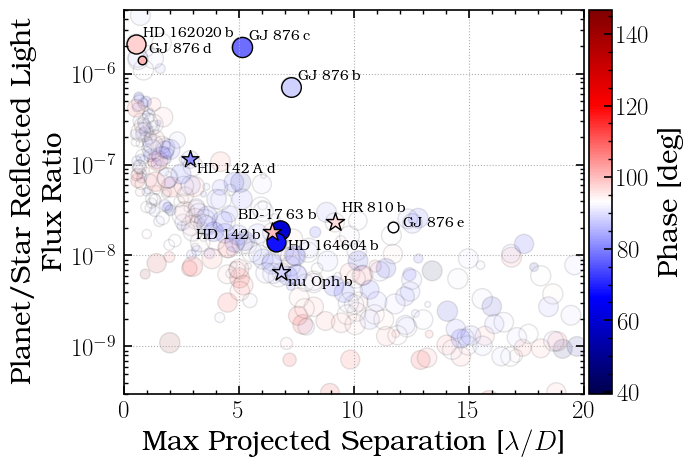

In [5]:
import matplotlib as mpl


ind = np.where((np.array(orbits['MaxProjectedSeparation_lod_gmagaox']) > 0.5) & 
               (np.array(orbits['dec']) < 20) & 
               (np.array(orbits['dec']) > -65) 
              )[0]

rad = np.array(orbits['PlanetRadiuse'])[ind]
spt = np.array(orbits['SpT Number'])[ind]


plotx = np.array(orbits['MaxProjectedSeparation_lod_gmagaox'])[ind]
ploty = np.array(orbits['ContrastAtMaxProj'])[ind]
phases = np.array(orbits['PhaseAtMaxProj'])[ind]
sepau = np.array(orbits['MaxProjectedSeparation_au'])[ind]
sepmas = np.array(orbits['MaxProjectedSeparation_mas'])[ind]
filt = "i'"
xaxis_label = r'\[ \mathrm{Max\; Projected\; Separation}\; [\lambda/D]\]'
annotation_text = r"$$\mathrm{For}\; i'\; filter, \;D = 25.4m\$$"
output_file_name = 'TargetList-GMagAOX-Max-separation-contrast'

colorby = phases
norm = mpl.colors.Normalize(vmin=min(phases), vmax=np.max(phases))

%matplotlib inline
fig = plt.figure()

ax = fig.add_gridspec(top=0.75, right=0.7).subplots()

a1 = ax.scatter(plotx, ploty, 
            c=phases, cmap='seismic', s=rad*15, alpha =0.1, norm=norm, edgecolor='black')

offsetsDict = {
    'GJ 876 b':(5,5),
    'GJ 876 c':(5,5),
    'GJ 876 e':(7,0),
    'GJ 876 d':(5,5),
    'HD 162020 b':(5,5),
    'BD-17 63 b':(-30,8),
    'HD 164604 b':(8,-5)
    }
names = [orbits['pl_name'][i] for i in ind3]
for j,i in enumerate(ind3):
    x = np.array(orbits['MaxProjectedSeparation_lod_gmagaox'][i])
    y = np.array(orbits['ContrastAtMaxProj'][i])
    p = np.array(orbits['PhaseAtMaxProj'][i])
    r = np.array(orbits['PlanetRadiuse'][i])
    ax.scatter(x, y, c=p, cmap='seismic', lw=1, norm=norm, s=r*15, edgecolors='black')
    ax.annotate(names[j], xy = (x,y), xytext = offsetsDict[names[j]], textcoords = 'offset points')

    

offsetsDict = {
    'HR 810 b':(5,8),
    'HD 142 c':(5,-10),
    'HD 142 b':(-55,-5),
    'HD 142 A d':(5,-10),
    'HD 80883 b':(5,-10),
    'nu Oph c':(5,-10),
    'nu Oph b':(5,-10)
    }
names = [orbits['pl_name'][i] for i in ind4]
for j,i in enumerate(ind4):
    x = np.array(orbits['MaxProjectedSeparation_lod_gmagaox'][i])
    y = np.array(orbits['ContrastAtMaxProj'][i])
    p = np.array(orbits['PhaseAtMaxProj'][i])
    r = np.array(orbits['PlanetRadiuse'][i])
    ax.scatter(x, y, c=p, cmap='seismic', lw=1, norm=norm, s=r*15, edgecolors='black', marker='*')
    ax.annotate(names[j], xy = (x,y), xytext = offsetsDict[names[j]], textcoords = 'offset points')
    

ax.set_yscale('log')
ax.set_xlim(0,20)
ax.set_ylim(bottom=3e-10, top=5e-6)
ax.set_xlabel(r'Max Projected Separation [$\lambda/D$]')
ax.set_ylabel('Planet/Star Reflected Light \n Flux Ratio')
ax.grid(ls=':')

cbarax = ax.inset_axes([1.01,0,0.05,1])
cmap = mpl.cm.seismic
norm = mpl.colors.Normalize(vmin=min(phases), vmax=max(phases))
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbarax, orientation="vertical")
cbarax.set_ylabel('Phase [deg]')

plt.savefig('GMagAO-X-planets-lod-vs-fluxcont-NSS-TargetedOrbitSearch.png', bbox_inches='tight')


In [6]:
def GetAveOrbSep(arr):
    ''' get the average planet-star separation throughout an orbit
    '''
    aa = arr['SepsInPlaneOfOrbit_au'].replace('[','').replace(']','').replace('\n','').replace(' ',',').replace(',,',',')
    aa = aa.split(',')
    aas = []
    for aaa in aa:
        try:
            aas.append(float(aaa))
        except:
            pass
    aas = np.array(aas)
    return np.mean(aas)

# Compute equilibrium temperature for each planet
Teqs = []
for i in range(len(orbits)):
    a = GetAveOrbSep(orbits.loc[i])
    Teqs.append(ComputeTeq(orbits.loc[i]['StarTeff'], orbits.loc[i]['StarRad']*u.Rsun, a*u.au))
orbits['Teqs'] = Teqs

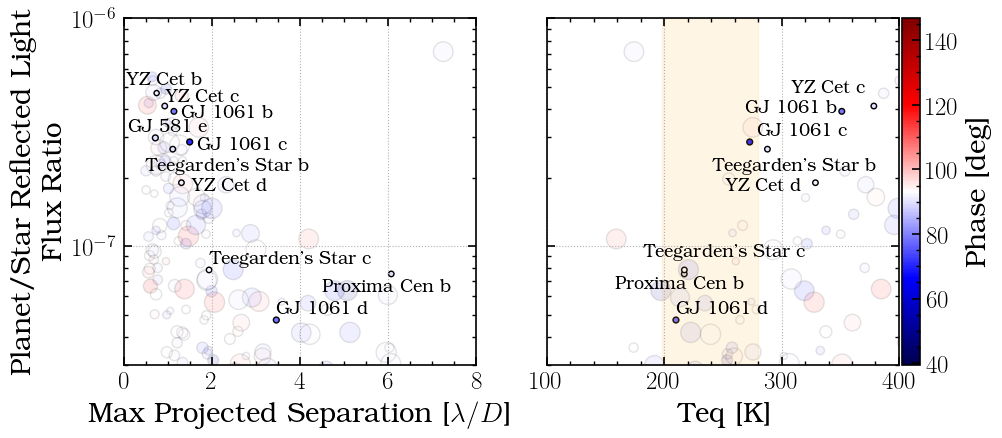

In [14]:
import matplotlib as mpl
ind = np.where((np.array(orbits['MaxProjectedSeparation_lod_gmagaox']) > 0.5) & 
               (np.array(orbits['dec']) < 20) & 
               (np.array(orbits['dec']) > -65)
              )[0]

ind2 = np.where((np.array(orbits['MaxProjectedSeparation_lod_gmagaox']) > 0.5) & 
               (np.array(orbits['dec']) < 20) & 
               (np.array(orbits['dec']) > -65) &
               (np.array(orbits['pl_bmasse']) <= 2)
              )[0]

names = [orbits['pl_name'][i] for i in ind2]

xaxis_label = r'\[ \mathrm{Max\; Projected\; Separation}\; [\lambda/D]\]'
annotation_text = r"$$\mathrm{For}\; i'\; filter, \;D = 25.4m\$$"


fig, axes = plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(10,4.5))

ax = axes[0]


rad = np.array(orbits['PlanetRadiuse'])[ind]
spt = np.array(orbits['SpT Number'])[ind]
plotx = np.array(orbits['MaxProjectedSeparation_lod_gmagaox'])[ind]
ploty = np.array(orbits['ContrastAtMaxProj'])[ind]
phases = np.array(orbits['PhaseAtMaxProj'])[ind]
sepau = np.array(orbits['MaxProjectedSeparation_au'])[ind]
sepmas = np.array(orbits['MaxProjectedSeparation_mas'])[ind]

a1 = ax.scatter(plotx, ploty, 
            c=phases, cmap='seismic', s=rad*15, alpha =0.1, norm=norm, edgecolor='black')

rad = np.array(orbits['PlanetRadiuse'])[ind2]
spt = np.array(orbits['SpT Number'])[ind2]
plotx = np.array(orbits['MaxProjectedSeparation_lod_gmagaox'])[ind2]
ploty = np.array(orbits['ContrastAtMaxProj'])[ind2]
phases = np.array(orbits['PhaseAtMaxProj'])[ind2]
sepau = np.array(orbits['MaxProjectedSeparation_au'])[ind2]
sepmas = np.array(orbits['MaxProjectedSeparation_mas'])[ind2]
a = ax.scatter(plotx, ploty, 
            c=phases, cmap='seismic', s=rad*15, alpha =1, norm=norm, edgecolor='black')
    
ax.axvspan(198,280, color='orange', alpha=0.1)


offsetsDict = {
    'Proxima Cen b':(-50,-12),
    'tau Cet h':(0,0),
    'tau Cet g':(0,0),
    'YZ Cet d':(7,-5),
    'YZ Cet b':(-22,7),
    'YZ Cet c':(0,4),
    "Teegarden's Star b":(-20,-15),
    "Teegarden's Star c":(0,5),
    "Teegarden's Star d":(0,0),
    'GJ 1061 b':(5,-4),
    'GJ 1061 d':(0,5),
    'GJ 1061 c':(5,-5),
    'GJ 581 e':(-20,5),
    'HD 20781 b':(0,5)
}

for j,name in enumerate(names):
    ax.annotate(name, xy = (plotx[j],ploty[j]), xytext = offsetsDict[name], textcoords = 'offset points', fontsize=13)


ax.set_yscale('log')
ax.set_xlim(0,8)
ax.set_ylim(bottom=3e-8, top=1e-6)
ax.set_xlabel(r'Max Projected Separation [$\lambda/D$]')
ax.set_ylabel('Planet/Star Reflected Light \n Flux Ratio')
ax.grid(ls=':')



ax = axes[1]

plotx = np.array(orbits['Teqs'])[ind]
ploty = np.array(orbits['ContrastAtMaxProj'])[ind]
phases = np.array(orbits['PhaseAtMaxProj'])[ind]
sepau = np.array(orbits['MaxProjectedSeparation_au'])[ind]
sepmas = np.array(orbits['MaxProjectedSeparation_mas'])[ind]
rad = np.array(orbits['PlanetRadiuse'])[ind]

a1 = ax.scatter(plotx, ploty, 
            c=phases, cmap='seismic', s=rad*15, alpha =0.1, norm=norm, edgecolor='black')


plotx = np.array(orbits['Teqs'])[ind2]
ploty = np.array(orbits['ContrastAtMaxProj'])[ind2]
phases = np.array(orbits['PhaseAtMaxProj'])[ind2]
sepau = np.array(orbits['MaxProjectedSeparation_au'])[ind2]
sepmas = np.array(orbits['MaxProjectedSeparation_mas'])[ind2]
rad = np.array(orbits['PlanetRadiuse'])[ind2]

a = ax.scatter(plotx, ploty, 
            c=phases, cmap='seismic', s=rad*15, alpha =1, norm=norm, edgecolor='black')
    
ax.axvspan(198,280, color='orange', alpha=0.1)


offsetsDict = {
    'Proxima Cen b':(-50,-10),
    'tau Cet h':(0,0),
    'tau Cet g':(0,0),
    'YZ Cet d':(-65,-5),
    'YZ Cet b':(0,0),
    'YZ Cet c':(-60,10),
    "Teegarden's Star b":(-40,-15),
    "Teegarden's Star c":(-30,10),
    "Teegarden's Star d":(0,0),
    'GJ 1061 b':(-70,0),
    'GJ 1061 d':(0,5),
    'GJ 1061 c':(5,5),
    'GJ 581 e':(0,5),
    'HD 20781 b':(0,5)
}

for j,name in enumerate(names):
    ax.annotate(name, xy = (plotx[j],ploty[j]), xytext = offsetsDict[name], textcoords = 'offset points', fontsize=13)


ax.set_yscale('log')
ax.set_xlim(100,400)
ax.set_xlabel('Teq [K]')
ax.grid(ls=':')


cbarax = ax.inset_axes([1.01,0,0.05,1])
fig.colorbar(a, cax=cbarax, orientation="vertical")

cbarax.set_ylabel('Phase [deg]')
plt.savefig('Terrestrial-planets-selected.png', bbox_inches='tight')
